### __Introducing of additional non-time features__

In this notebook, we will introduce further features which are likely to impact the marginal CO2 emissions. These include the electricity demand as well as the available generation.
Moreover, the energy flow from generators of outside South Australia (remember that we filtered for South Australia in notebook 3) is added as a feature.

In [9]:
import numpy as np
import pandas as pd

In [36]:
df = pd.read_pickle('../../big_data/train_time_features.pkl')
df.head()

,Price,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,...,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,horizon0
2019-08-01 03:55:00,79.52391,0.380340,0,2019,-0.500000,8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01 03:50:00,79.17710,0.456409,0,2019,-0.866025,5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01 03:45:00,85.14416,0.573436,0,2019,-1.000000,-1.836970e-16,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01 03:40:00,84.78689,0.573436,0,2019,-0.866025,-5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01 03:35:00,84.78346,0.573436,0,2019,-0.500000,-8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,0.38034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
demand = pd.read_csv('../../big_data/demand.csv', index_col=-1, parse_dates=True)
demand.drop(columns=["SETTLEMENTDATE", "I", "INTERVENTION"], inplace=True)
demand = demand[(demand.index >= df.index.min()) & (demand.index <= df.index.max())]

assert demand.index.min() == df.index.min()
assert demand.index.max() == df.index.max()

demand.head()

,TOTALDEMAND,AVAILABLEGENERATION
start-of-interval,,
2009-07-01 04:00:00,1004.32,3043.771
2009-07-01 04:05:00,1007.58,3043.694
2009-07-01 04:10:00,1019.33,3045.307
2009-07-01 04:15:00,1025.24,3045.436
2009-07-01 04:20:00,1050.50,3043.964


In [6]:
print(demand.index.min())
print(demand.index.max())

print(df.index.min())
print(df.index.max())

2009-07-01 04:00:00
2019-08-01 03:55:00
2009-07-01 04:00:00
2019-08-01 03:55:00


### __Checking for regular time granularity (5 min) in the demand dataset__

In order to check if our demand dataset contains any gaps, we first generate a datarange reflecting the min and max values of the demand datetimeindex.

In [9]:
len(pd.date_range(start=demand.index.min(), end=demand.index.max(), freq="5min"))

1060704

In [10]:
test = demand.groupby(demand.index).agg({"TOTALDEMAND": "nunique","AVAILABLEGENERATION":"nunique"})
print(test.TOTALDEMAND.value_counts()) 
print(test.AVAILABLEGENERATION.value_counts())

#all TOTALDEMANDS and AVAILABLEGENERATION are unique

1    1060704
Name: TOTALDEMAND, dtype: int64
1    1060704
Name: AVAILABLEGENERATION, dtype: int64


The number of rows corresponds the the length of our hypothetical daterange (cell above). Hence we can conclude that no gaps are present in the dataset.

### __Addition of non-time features__

Note that the feature of available generation is introduced in a feature-engineered fashion together with the total demand feature. In that way, it reflects how far the energy grid is used to capacity.

In [37]:
demand = demand.groupby(demand.index).mean()

In [38]:
df["demand"] = demand.TOTALDEMAND
df["demand_capacity"] = demand.TOTALDEMAND/demand.AVAILABLEGENERATION

In [39]:
print(df.shape)
df.head()

(1060704, 25)


,Price,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,...,lag6,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity
2019-08-01 03:55:00,79.52391,0.380340,0,2019,-0.500000,8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1264.04,0.414510
2019-08-01 03:50:00,79.17710,0.456409,0,2019,-0.866025,5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1250.76,0.410810
2019-08-01 03:45:00,85.14416,0.573436,0,2019,-1.000000,-1.836970e-16,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1261.41,0.413046
2019-08-01 03:40:00,84.78689,0.573436,0,2019,-0.866025,-5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1243.33,0.407500
2019-08-01 03:35:00,84.78346,0.573436,0,2019,-0.500000,-8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1248.97,0.409481


### __Addition of the interconnectors feature__

This feature reflects how much electricity is being imported into the region of South Australia.

In [40]:
interconnectors = pd.read_csv('../../big_data/interconnectors.csv', index_col=-1, parse_dates=True)
interconnectors.drop(columns=["SETTLEMENTDATE", "I", "INTERCONNECTORID"], inplace=True)
interconnectors = interconnectors[(interconnectors.index >= df.index.min()) & (interconnectors.index <= df.index.max())]

assert interconnectors.index.min() == df_mean2.index.min()
assert interconnectors.index.max() == df_mean2.index.max()

interconnectors.head()

NameError: name 'df_mean2' is not defined

When trying to load the file together with our assertions, we get an error. That is due to that the interconncectors dataframe datetimeindex starts later.

__Watch:__

In [ ]:
print(interconnectors.shape)
print(interconnectors.index.min())
print(interconnectors.index.max())

print(df.index.min())

We will take care of that later as we delete all NaNs from our dataframe below.

In [41]:
interconnectors.groupby(interconnectors.index).agg({"MWFLOW":"nunique"}).MWFLOW.value_counts()

1    1004400
2      38496
Name: MWFLOW, dtype: int64

In [42]:
interconnectors = interconnectors.groupby(interconnectors.index).mean()
interconnectors.shape

(1042896, 1)

In [44]:
df["interconnector"] = interconnectors.MWFLOW
df.head()

,Price,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,...,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector
2019-08-01 03:55:00,79.52391,0.380340,0,2019,-0.500000,8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1264.04,0.414510,33.03363
2019-08-01 03:50:00,79.17710,0.456409,0,2019,-0.866025,5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1250.76,0.410810,24.34067
2019-08-01 03:45:00,85.14416,0.573436,0,2019,-1.000000,-1.836970e-16,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1261.41,0.413046,25.68808
2019-08-01 03:40:00,84.78689,0.573436,0,2019,-0.866025,-5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1243.33,0.407500,11.98062
2019-08-01 03:35:00,84.78346,0.573436,0,2019,-0.500000,-8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1248.97,0.409481,17.02276


In [45]:
def correct_timedelta(df, time_diff):
    '''
    df.index must be DateTimeIndex
    Returns two lists
    df=table_of_interest
    col="column_of_interest"
    time_diff=time_diff in seconds as int
    '''
    lst = []
    lst_i = []
    count = 0
    for i in df.index:
        count += 1
        if count >= len(df):
            break
        delta = abs(df.index[count] - df.index[count-1])
        if int(delta.total_seconds()) != int(time_diff):
            lst.append(("from index {} on, it has been {} s or {} h.".format(count-1,int(delta.total_seconds()),(int(delta.total_seconds()/3600)))))
            lst_i.append((df.index[count-1],int(delta.total_seconds())))
    return lst, lst_i

In [46]:
lst1, _ = correct_timedelta(df, 300)

In [47]:
len(lst1)

0

In [48]:
print(df.shape)
df.isna().any()

(1060704, 26)


Price                     True
CO2E_EMISSIONS_FACTOR     True
weekday                  False
year                     False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
month_sin                False
month_cos                False
lag1                      True
lag2                      True
lag3                      True
lag4                      True
lag5                      True
lag6                      True
lag7                      True
lag8                      True
lag9                      True
lag10                     True
lag11                     True
lag12                     True
horizon0                  True
demand                   False
demand_capacity          False
interconnector            True
dtype: bool

In our current dataframe, we have a set of columns featuring NaN values. For the columns we created in the course of time feature engineering, we know that they sit either at the very beginning or very end of each respective column. Hence, considering our massive amount of data, it would be no harm to simply drop those values. For the price and CO2 emissions, we have to be more cautious (see below).

In [51]:
file_path = '../../big_data/df_dirty_interconnectors.pkl'
pd.to_pickle(df, file_path)

### __Data imputation of time series__

Due to the nature of time series data, the imputation of missing values needs extra attention. The potential presence of time series trends and seasonality renders imputations using e.g. mean or median deduced from the entire dataset little useful. Instead, any imputation should rather consider the local value range around a NaN value. In the following, we will see one approach of how that works.

<img src="../images/time_series_imputation.jpg"> <br/>
source: https://www.hindawi.com/journals/mpe/2010/513810/fig9/

In [4]:
df = pd.read_pickle('../../big_data/df_dirty_interconnectors.pkl')
df.head()

,Price,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,...,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector
2019-08-01 03:55:00,79.52391,0.380340,0,2019,-0.500000,8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1264.04,0.414510,33.03363
2019-08-01 03:50:00,79.17710,0.456409,0,2019,-0.866025,5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1250.76,0.410810,24.34067
2019-08-01 03:45:00,85.14416,0.573436,0,2019,-1.000000,-1.836970e-16,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1261.41,0.413046,25.68808
2019-08-01 03:40:00,84.78689,0.573436,0,2019,-0.866025,-5.000000e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1243.33,0.407500,11.98062
2019-08-01 03:35:00,84.78346,0.573436,0,2019,-0.500000,-8.660254e-01,0.707107,0.707107,-0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1248.97,0.409481,17.02276


In [5]:
# here, we calculate the local mean over a window of always 30 rows

df_impute = df.assign(rolling_mean=df['CO2E_EMISSIONS_FACTOR'].rolling(window=30, min_periods=1).mean())

In [6]:
df_impute.head(50)

,Price,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,...,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector,rolling_mean
2019-08-01 03:55:00,79.52391,0.380340,0,2019,-5.000000e-01,8.660254e-01,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1264.04,0.414510,33.03363,0.380340
2019-08-01 03:50:00,79.17710,0.456409,0,2019,-8.660254e-01,5.000000e-01,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1250.76,0.410810,24.34067,0.418374
2019-08-01 03:45:00,85.14416,0.573436,0,2019,-1.000000e+00,-1.836970e-16,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1261.41,0.413046,25.68808,0.470062
2019-08-01 03:40:00,84.78689,0.573436,0,2019,-8.660254e-01,-5.000000e-01,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1243.33,0.407500,11.98062,0.495905
2019-08-01 03:35:00,84.78346,0.573436,0,2019,-5.000000e-01,-8.660254e-01,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1248.97,0.409481,17.02276,0.511412
2019-08-01 03:30:00,85.51143,0.573436,0,2019,5.665539e-16,-1.000000e+00,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1263.94,0.415815,42.78340,0.521749
2019-08-01 03:25:00,81.06731,0.000000,0,2019,5.000000e-01,-8.660254e-01,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1292.53,0.424114,56.55735,0.447213
2019-08-01 03:20:00,86.22969,0.573436,0,2019,8.660254e-01,-5.000000e-01,0.707107,0.707107,-0.866025,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,1299.90,0.428570,78.54688,0.462991
2019-08-01 03:15:00,85.55658,0.573436,0,2019,1.000000e+00,2.832769e-16,0.707107,0.707107,-0.866025,-0.500000,...,0.380340,NaN,NaN,NaN,NaN,NaN,1267.53,0.417681,50.00000,0.475263
2019-08-01 03:10:00,85.52487,0.573436,0,2019,8.660254e-01,5.000000e-01,0.707107,0.707107,-0.866025,-0.500000,...,0.456409,0.380340,NaN,NaN,NaN,NaN,1257.55,0.413710,39.04777,0.485080


In [7]:
df_impute.isna().any()

Price                     True
CO2E_EMISSIONS_FACTOR     True
weekday                  False
year                     False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
month_sin                False
month_cos                False
lag1                      True
lag2                      True
lag3                      True
lag4                      True
lag5                      True
lag6                      True
lag7                      True
lag8                      True
lag9                      True
lag10                     True
lag11                     True
lag12                     True
horizon0                  True
demand                   False
demand_capacity          False
interconnector            True
rolling_mean              True
dtype: bool

In [11]:
#here we use the numpy.where() method to replace only NaNs with values from the rolling_mean column
df_impute['CO2E_EMISSIONS_FACTOR'] = np.where(df_impute['CO2E_EMISSIONS_FACTOR'].isnull(),\
                                  df_impute['rolling_mean'], df_impute['CO2E_EMISSIONS_FACTOR'])

df_impute.drop(columns='rolling_mean', inplace=True)

In [12]:
#let's see if everything worked
df_impute.isna().any()

Price                     True
CO2E_EMISSIONS_FACTOR     True
weekday                  False
year                     False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
month_sin                False
month_cos                False
lag1                      True
lag2                      True
lag3                      True
lag4                      True
lag5                      True
lag6                      True
lag7                      True
lag8                      True
lag9                      True
lag10                     True
lag11                     True
lag12                     True
horizon0                  True
demand                   False
demand_capacity          False
interconnector            True
dtype: bool

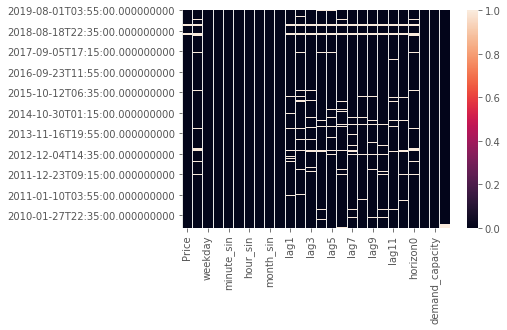

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

fig = sns.heatmap(df.isna(), yticklabels=100000)

In [ ]:
pd.set_option('display.max_rows', None)
df_impute[df_impute['CO2E_EMISSIONS_FACTOR'].isna()]

In [52]:
df_clean = df.dropna()

In [53]:
print(df_clean.shape)
df_clean.isna().any()

(807150, 26)


Price                    False
CO2E_EMISSIONS_FACTOR    False
weekday                  False
year                     False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
month_sin                False
month_cos                False
lag1                     False
lag2                     False
lag3                     False
lag4                     False
lag5                     False
lag6                     False
lag7                     False
lag8                     False
lag9                     False
lag10                    False
lag11                    False
lag12                    False
horizon0                 False
demand                   False
demand_capacity          False
interconnector           False
dtype: bool

In [55]:
file_path = '../../big_data/df_clean_interconnectors.pkl'
pd.to_pickle(df_clean, file_path)